# Imports

In [1]:
# Imports for data loading
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for model learning
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Imports for model evaluation
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassSpecificity

# Other imports
import datetime
from typing import Tuple, List

# Cells for Colab

In [2]:
# import zipfile
# from google.colab import drive

# drive.mount("/content/drive")
# zip_path = "/content/drive/My Drive/dataset.zip"
# extract_path = "/content"

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extract_path)

# print(os.listdir(extract_path))

# Data Loading

In [3]:
# Dima's paths
# TRAIN_PATH = r"C:\Users\aquas\Jupyter\ML_Project_git\dataset\train"
# TEST_PATH = r"C:\Users\aquas\Jupyter\ML_Project_git\dataset\test"

# Tykhin's paths
TRAIN_PATH = f"D:\\Tykhon\\Downloads\\data_folder\\train"
TEST_PATH = f"D:\\Tykhon\\Downloads\\data_folder\\test"

# Colab paths
#TRAIN_PATH = "/content/train"
#TEST_PATH = "/content/test"

train_set = datasets.ImageFolder(root=TRAIN_PATH)
test_set = datasets.ImageFolder(root=TEST_PATH)

# Print dataset configuration
print(f"\nTraining set size: {len(train_set)} images")
print(f"Test set size: {len(test_set)} images")

class_names = train_set.classes
print(f"\nClasses [{len(class_names)}]: {class_names}")



Training set size: 23788 images
Test set size: 5094 images

Classes [4]: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9312296..2.171491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8694293..1.3680577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9312296..2.220933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3008665..2.220933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9312296..2.072607].


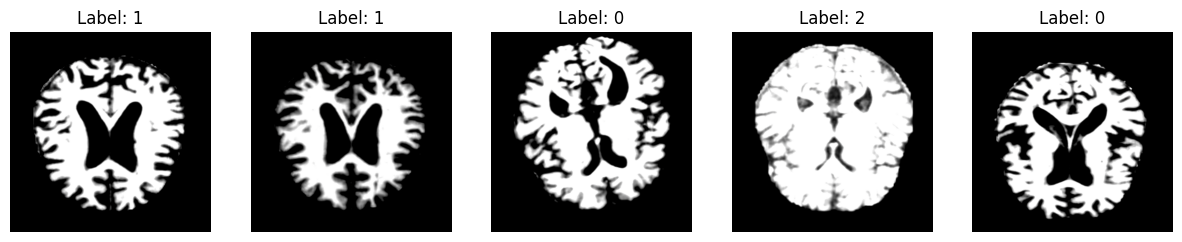

In [4]:
# Apply custom transformations
custom_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.CenterCrop(380),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2954581669589034, 0.29541042352786206, 0.29537371119537875], std=[0.31727746077062646, 0.31729778651393764, 0.31726590300772206]),
])
train_set_transformed = datasets.ImageFolder(root=TRAIN_PATH, transform=custom_transform)
test_set_transformed = datasets.ImageFolder(root=TEST_PATH, transform=custom_transform)

# Show 5 pictures
def show_pictures(dataset: datasets.ImageFolder, pictures_num: int=5) -> None:
    start_index = 0

    fig, axes = plt.subplots(nrows=1, ncols=pictures_num, figsize=(15, 45))

    for _, ax in enumerate(axes):
        image, label = dataset[np.random.randint(0, 23787)]
        image = image.permute(1, 2, 0).numpy()
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

show_pictures(train_set_transformed)

# Model Loading

In [5]:
# Check CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# # Load EfficientNet model
# model = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights.DEFAULT).to(device)

# # Set parameter training to True
# for param in model.features.parameters():
#     param.requires_grad = True

# # Define classifier
# model.classifier = torch.nn.Sequential(
#     #torch.nn.Dropout(p=0.1, inplace=True), LOra!!! binary cross entropy -for multi labeling!!! mini-batching
#     torch.nn.Linear(in_features=model.classifier[1].in_features,
#                     out_features=4,
#                     bias=True)).to(device)

# # Define loss function and optimizer
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# # Load ResNet model
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# # Set parameter training to True
# for param in model.features.parameters():
#     param.requires_grad = True

# # Define classifier
# model.classifier = torch.nn.Sequential(
#     #torch.nn.Dropout(p=0.1, inplace=True), LOra!!! binary cross entropy -for multi labeling!!! mini-batching
#     torch.nn.Linear(in_features=model.classifier[1].in_features,
#                     out_features=4,
#                     bias=True)).to(device)

# # Define loss function and optimizer
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Load DenseNet model
model = torchvision.models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT).to(device)

# Set parameter training to True
for param in model.features.parameters():
    param.requires_grad = True

# Define classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=model.classifier.in_features,
                    out_features=4,
                    bias=True)).to(device)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.01)

In [ ]:
# # Load MobileNet model
# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT).to(device)

# # Set parameter training to True
# for param in model.features.parameters():
#     param.requires_grad = True

# # Define classifier
# model.classifier = torch.nn.Sequential(
#     #torch.nn.Dropout(p=0.1, inplace=True), LOra!!! binary cross entropy -for multi labeling!!! mini-batching
#     torch.nn.Linear(in_features=model.classifier[1].in_features,
#                     out_features=4,
#                     bias=True)).to(device)

# # Define loss function and optimizer
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Settings

In [9]:
# Number of classes
num_classes = 4

In [10]:
# Loading custom weights (CHANGE VERSION EVERY NEW RUN!)
VERSION = 0
if VERSION != 0:
    WEIGHTS_PATH = f"model_weights_v{VERSION}.pt"
    model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=False))

In [11]:
# Set batch size
batch_size = 16
train_dataloader = DataLoader(train_set_transformed, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set_transformed, batch_size=batch_size, shuffle=False)

In [12]:
# Set number of epochs
epochs_num = 10

# Functions

### Some functions, idk

In [ ]:
# Log results of every epoch
def save_log(train_loss: float, train_acc: float, test_loss:float, test_acc: float):
    log_data = f"\nTrain loss: {train_loss:.5f} | Train acc: {((train_acc)*100):.2f}% | Test loss: {test_loss:.5f} | Test acc: {((test_acc)*100):.2f}% [{datetime.datetime.now().strftime('%H:%M:%S')}]\n"
    print(log_data)

    with open(f"log_v{VERSION+1}.txt", "a") as file:
        file.write(log_data)
    #Save to drive
    # with open(f"/content/drive/My Drive/log_v{VERSION+1}.txt", "a") as file:
    #     file.write(log_data)

In [16]:
# Save weight of the model with best accuracy
def model_weight_save(test_acc: float, best_acc: float) -> float:
    if test_acc > best_acc:
        best_acc = test_acc
        SAVE_PATH = f"model_best_weights_v{VERSION+1}.pt"
        torch.save(model.state_dict(), SAVE_PATH)

        # Log save
        print(f"\nWeights saved to {SAVE_PATH}")
        with open(f"weigth_v{VERSION+1}.txt", "a") as file:
            file.write(f"\nWeights saved to {SAVE_PATH}\n\n")
    return best_acc

In [17]:
# Evaluation of model peformance
def model_perfomance_eval(test_y_pred, y, precision_metric, specificity_metric, recall_metric, precision_array: list, specificity_array: list, recall_array: list, f1_score_array: list) -> None:
    precision = precision_metric(test_y_pred, y)
    specificity = specificity_metric(test_y_pred, y)
    recall = recall_metric(test_y_pred, y)
    f1_score = (2 * precision * recall) / (precision + recall)

    precision_array.append(precision.item())
    specificity_array.append(specificity.item())
    recall_array.append(recall.item())
    f1_score_array.append(f1_score.item())


    # Log perfomance of every epoch
    print(f"\nPrecision: {precision:.5f} | Specificity: {specificity:.5f} | Recall: {recall:.5f} | F1-score: {f1_score:.5f}")

### Save Results

In [18]:
# Save loss plot
def save_loss_plot(train_loss_array: list, test_loss_array: list) -> None:
    plt.plot(train_loss_array, label="Train Loss", linestyle="-", color="blue", marker="o", markersize=6, linewidth=2)
    plt.plot(test_loss_array, label="Test Loss", linestyle="--", color="orange", marker="s", markersize=6, linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Graph: v{VERSION+1}", weight="bold")
    plt.legend(loc="upper right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    plt.axhline(y=0, color="gray", linestyle="-", linewidth=1, alpha=0.7)
    plt.savefig(f"loss_graph_v{VERSION+1}.png")
    # Save in drive
    #plt.savefig(f"/content/drive/My Drive/loss_graph_v{VERSION+1}.png")

In [19]:
# Save acc plot
def save_acc_plot(train_acc_array: list, test_acc_array: list) -> None:
    plt.plot(train_acc_array, label="Train Accuracy", linestyle="-", color="blue", marker="o", markersize=6, linewidth=2)
    plt.plot(test_acc_array, label="Test Accuracy", linestyle="--", color="orange", marker="s", markersize=6, linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Graph: v{VERSION+1}", weight="bold")
    plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    plt.axhline(y=0, color="gray", linestyle="-", linewidth=1, alpha=0.7)
    plt.savefig(f"acc_graph_v{VERSION+1}.png")
    # Save in drive
    #plt.savefig(f"/content/drive/My Drive/acc_graph_v{VERSION+1}.png")

In [ ]:
def save_top_mistakes(mistakes: list, X, y, test_pred_labels, test_y_prob):
    wrong = test_pred_labels != y
    for idx in range(len(wrong)):
        if wrong[idx]:
            mistakes.append({
                'image': X[idx].cpu(),
                'true': y[idx].item(),
                'pred': test_pred_labels[idx].item(),
                'conf': test_y_prob[idx][test_pred_labels[idx]].item()
            })

# Training

In [ ]:
# Variables for evaluation
best_acc = 0
train_loss_array = []
train_acc_array = []
test_loss_array = []
test_acc_array = []
precision_array = []
specificity_array = []
recall_array = []
f1_score_array = []
mistakes = []
all_predictions = torch.empty(0, dtype=torch.long)
all_probabilities = torch.empty(0, num_classes)
all_labels = torch.empty(0, dtype=torch.long)

precision_metric = MulticlassPrecision(num_classes=num_classes, average="macro").to(device)
recall_metric = MulticlassRecall(num_classes=num_classes, average="macro").to(device)
specificity_metric = MulticlassSpecificity(num_classes=num_classes, average='macro').to(device)

# Training loop
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}\n---------")

    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_pred_labels = y_pred.argmax(dim=1)
        train_acc += (train_pred_labels == y).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch % 10 == 0):
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples [{datetime.datetime.now().strftime('%H:%M:%S')}]")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)
    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)

    # Evaluation
    model.eval()
    test_loss, test_acc = 0, 0
    print(f"Evaluation... [{datetime.datetime.now().strftime('%H:%M:%S')}]")

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_y_pred = model(X)
            test_y_prob = test_y_pred.softmax(dim=1)
            test_loss += loss_fn(test_y_pred, y).item()
            test_pred_labels = test_y_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()

            all_probabilities = torch.cat((all_probabilities, test_y_prob.cpu()), dim=0)
            all_predictions = torch.cat((all_predictions, test_pred_labels.cpu()), dim=0)
            all_labels = torch.cat((all_labels, y.cpu()), dim=0)

            save_top_mistakes(mistakes, X, y, test_pred_labels, test_y_prob)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader.dataset)
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)

    scheduler.step(test_loss)

    save_log(train_loss, train_acc, test_loss, test_acc)
    best_acc = model_weight_save(test_acc, best_acc)

    model_perfomance_eval(test_y_pred, y, precision_metric, specificity_metric, recall_metric, precision_array, specificity_array, recall_array, f1_score_array)

# Saving Results

In [134]:
# Weights extra save
torch.save(model.state_dict(), f"model_weights_v{VERSION+1}.pt")
# Save to drive
# torch.save(model.state_dict(), f"/content/drive/My Drive/model_weights_v{VERSION+1}.pt")

In [ ]:
# Model save
torch.save(model, f"model_v{VERSION+1}.pt")
# Save to drive
torch.save(model, f"/content/drive/My Drive/model_v{VERSION+1}.pt")

In [ ]:
save_loss_plot(train_loss_array, test_loss_array)

In [ ]:
save_acc_plot(train_acc_array, test_acc_array)

In [ ]:
# Save plot for top mistakes
mistakes.sort(key=lambda x: x['conf'], reverse=True)
mistakes = mistakes[:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, mistake in enumerate(mistakes):
    ax = axes[idx//5, idx%5]
    ax.imshow(mistake['image'].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {mistake["pred"]}\nTrue: {mistake["true"]}\nConf: {mistake["conf"]:.2f}')
    
plt.savefig(f"top_mistakes_v{VERSION+1}.png")
# Save to drive
# plt.savefig(f"/content/drive/My Drive/top_mistakes_v{VERSION+1}.png")

In [ ]:
# Save arrays for all_predictions
visualisation_arrays = pd.DataFrame({
    "Precision": precision_array,
    "Specificity": specificity_array,
    "Recall": recall_array,
    "F1 Score": f1_score_array
})
visualisation_arrays.to_csv("visualisation_arrays.csv", index=False)
# Save to drive
# visualisation_arrays.to_csv("/content/drive/My Drive/visualisation_arrays.csv", index=False)

In [ ]:
# Save tensors for all_predictions
torch.save({
    "all_probabilities": all_probabilities,
    "all_predictions": all_predictions,
    "all_labels": all_labels
}, "/content/drive/My Drive/visualisation_tensors.pt") #Delete '/content/drive/My Drive/' to save localy